# `Практикум по программированию на языке Python`
<br>

## `Занятие 12: Torch JIT + C++ API`
<br><br>

### `Находнов Максим (nakhodnov17@gmail.com)`

#### `Москва, 2023`

In [1]:
%config Completer.use_jedi = True
%load_ext autoreload
%autoreload 2

In [2]:
import os

from IPython.display import Code

import zipfile

import numpy as np

import torch

import torchvision
from torchvision.models import resnet50, ResNet50_Weights


import matplotlib_inline
import matplotlib.pyplot as plt

matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')

In [3]:
os.makedirs('./images', exist_ok=True)
os.makedirs('./models', exist_ok=True)

## `TorchScript`

TorchScript — встроенный в PyTorch метод сериализации моделей. В отличии от `torch.save`/`torch.load`, сохранённые через TorchScript модели можно использовать в окружениях без интерпретатора Python, например, из C++. Это может быть удобно для написания высокопроизводительных многопоточных приложений и серверов. Другое преимущество — возможность производить оптимизации графа вычисления для ускорения инференса.

Однако, недостатком является ограниченная функциональность. TorchScript может сериализовывать только подмножество языка Python и библиотеки Pytorch. Подробнее смотрите в [документации](https://pytorch.org/docs/stable/jit.html).

### `Простейший пример`

Создадим модуль с разнообразными вычислениями:

In [4]:
class TestJIT(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.w = torch.nn.Parameter(torch.rand(10, 10))
        
        self.conv = torch.nn.Conv1d(1, 10, kernel_size=3, stride=2, bias=True)
        self.bn = torch.nn.BatchNorm1d(10, eps=.001)
        
    def forward(self, x: torch.Tensor):
        x.requires_grad_(True)
        logits = torch.linalg.norm(x @ self.w, dim=-1).sum()
        grads = torch.autograd.grad([logits], [x], create_graph=True)[0]
        
        if grads is not None:
            result = self.bn(self.conv(grads))
            return result.mean(dim=(1, 2))
        
        return grads

In [5]:
model = TestJIT()

x = torch.rand(7, 1, 10)
output = model(x)

model, x, output

(TestJIT(
   (conv): Conv1d(1, 10, kernel_size=(3,), stride=(2,))
   (bn): BatchNorm1d(10, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
 ),
 tensor([[[0.3710, 0.5259, 0.7339, 0.0636, 0.4653, 0.7657, 0.1799, 0.8208,
           0.1615, 0.8191]],
 
         [[0.3225, 0.8476, 0.9206, 0.8014, 0.0057, 0.9214, 0.7607, 0.5220,
           0.4878, 0.5808]],
 
         [[0.5191, 0.0499, 0.5815, 0.1461, 0.4487, 0.3243, 0.9824, 0.8225,
           0.4538, 0.5431]],
 
         [[0.9870, 0.9620, 0.5664, 0.5708, 0.8134, 0.3477, 0.2148, 0.1936,
           0.1652, 0.5802]],
 
         [[0.4131, 0.0683, 0.5123, 0.5953, 0.2780, 0.4822, 0.4101, 0.5341,
           0.2620, 0.8267]],
 
         [[0.1894, 0.4747, 0.5165, 0.2230, 0.6529, 0.5293, 0.4610, 0.9615,
           0.3528, 0.9323]],
 
         [[0.3214, 0.7080, 0.6457, 0.5189, 0.9948, 0.0372, 0.6194, 0.1008,
           0.9915, 0.9597]]], requires_grad=True),
 tensor([-0.0003, -0.0017,  0.0031,  0.0037,  0.0036, -0.0032, -0.0052],
      

Скомпилируем граф вычислений:

In [6]:
compiled_model = torch.jit.script(model)

compiled_output = compiled_model(x)

compiled_model, x, compiled_output

(RecursiveScriptModule(
   original_name=TestJIT
   (conv): RecursiveScriptModule(original_name=Conv1d)
   (bn): RecursiveScriptModule(original_name=BatchNorm1d)
 ),
 tensor([[[0.3710, 0.5259, 0.7339, 0.0636, 0.4653, 0.7657, 0.1799, 0.8208,
           0.1615, 0.8191]],
 
         [[0.3225, 0.8476, 0.9206, 0.8014, 0.0057, 0.9214, 0.7607, 0.5220,
           0.4878, 0.5808]],
 
         [[0.5191, 0.0499, 0.5815, 0.1461, 0.4487, 0.3243, 0.9824, 0.8225,
           0.4538, 0.5431]],
 
         [[0.9870, 0.9620, 0.5664, 0.5708, 0.8134, 0.3477, 0.2148, 0.1936,
           0.1652, 0.5802]],
 
         [[0.4131, 0.0683, 0.5123, 0.5953, 0.2780, 0.4822, 0.4101, 0.5341,
           0.2620, 0.8267]],
 
         [[0.1894, 0.4747, 0.5165, 0.2230, 0.6529, 0.5293, 0.4610, 0.9615,
           0.3528, 0.9323]],
 
         [[0.3214, 0.7080, 0.6457, 0.5189, 0.9948, 0.0372, 0.6194, 0.1008,
           0.9915, 0.9597]]], requires_grad=True),
 tensor([-0.0003, -0.0017,  0.0031,  0.0037,  0.0036, -0.0032, -0.0052],

Скомпилированная модель представляется статическим графом вычислений:

In [7]:
compiled_model.graph

graph(%self : __torch__.TestJIT,
      %x.1 : Tensor):
  %13 : bool = prim::Constant[value=0]()
  %11 : NoneType = prim::Constant()
  %10 : int = prim::Constant[value=-1]() # C:\Users\nahod\AppData\Local\Temp\ipykernel_904312\1534975405.py:12:51
  %3 : bool = prim::Constant[value=1]() # C:\Users\nahod\AppData\Local\Temp\ipykernel_904312\1534975405.py:11:25
  %8 : int = prim::Constant[value=1]() # C:\Users\nahod\AppData\Local\Temp\ipykernel_904312\1534975405.py:12:52
  %27 : int = prim::Constant[value=0]() # C:\Users\nahod\AppData\Local\Temp\ipykernel_904312\1534975405.py:13:70
  %41 : int = prim::Constant[value=2]() # C:\Users\nahod\AppData\Local\Temp\ipykernel_904312\1534975405.py:17:39
  %4 : Tensor = aten::requires_grad_(%x.1, %3) # C:\Users\nahod\AppData\Local\Temp\ipykernel_904312\1534975405.py:11:8
  %w : Tensor = prim::GetAttr[name="w"](%self)
  %7 : Tensor = aten::matmul(%x.1, %w) # C:\Users\nahod\AppData\Local\Temp\ipykernel_904312\1534975405.py:12:35
  %12 : int[] = prim::Lis

In [8]:
print(compiled_model.code)

def forward(self,
    x: Tensor) -> Optional[Tensor]:
  _0 = torch.requires_grad_(x)
  w = self.w
  _1 = torch.linalg_norm(torch.matmul(x, w), None, [-1])
  logits = torch.sum(_1)
  _2 = torch.autograd.grad([logits], [x], None, None, True)
  grads = _2[0]
  if torch.__isnot__(grads, None):
    grads0 = unchecked_cast(Tensor, grads)
    bn = self.bn
    conv = self.conv
    result = (bn).forward((conv).forward(grads0, ), )
    _3 : Optional[Tensor] = torch.mean(result, [1, 2])
  else:
    _3 = grads
  return _3



Скомпилированная модель может использоваться для обучения также, как и обычный модуль. При этом, обучение можно перенести в C++.

In [9]:
output.sum().backward()
model.w.grad

tensor([[ 2.9201e-09, -6.7689e-09, -7.8223e-09, -8.3183e-09,  2.4734e-09,
         -2.4897e-09, -6.2544e-09, -5.4434e-09, -2.6902e-09, -1.4090e-08],
        [ 7.0069e-09,  2.4464e-09,  1.5613e-09, -3.5561e-09,  9.7548e-09,
          3.5048e-09,  2.2255e-09,  2.2375e-09,  5.2246e-09, -8.8927e-09],
        [ 2.4030e-08,  2.9519e-08,  3.4182e-08,  1.6250e-08,  3.2498e-08,
          2.5364e-08,  3.3221e-08,  2.7864e-08,  2.9862e-08,  9.1980e-09],
        [-1.2714e-09, -1.1711e-08, -1.4777e-08, -1.3128e-08, -2.1715e-09,
         -7.3968e-09, -1.3259e-08, -1.0643e-08, -7.5855e-09, -1.7862e-08],
        [ 5.4152e-08,  8.3695e-08,  1.0091e-07,  6.1051e-08,  7.3121e-08,
          6.9242e-08,  9.6041e-08,  7.9409e-08,  7.6996e-08,  5.4782e-08],
        [-6.4074e-09, -2.1669e-08, -2.7461e-08, -2.2222e-08, -9.1190e-09,
         -1.5692e-08, -2.5143e-08, -2.0244e-08, -1.5910e-08, -2.7672e-08],
        [-4.3820e-08, -9.1140e-08, -1.1024e-07, -7.5459e-08, -6.1656e-08,
         -6.9577e-08, -1.0269e-0

In [10]:
compiled_output.sum().backward()
# Градиент удвоился, так как модели разделяют веса
compiled_model.w.grad

tensor([[ 5.8402e-09, -1.3538e-08, -1.5645e-08, -1.6637e-08,  4.9468e-09,
         -4.9794e-09, -1.2509e-08, -1.0887e-08, -5.3805e-09, -2.8181e-08],
        [ 1.4014e-08,  4.8927e-09,  3.1225e-09, -7.1121e-09,  1.9510e-08,
          7.0097e-09,  4.4509e-09,  4.4750e-09,  1.0449e-08, -1.7785e-08],
        [ 4.8060e-08,  5.9038e-08,  6.8364e-08,  3.2500e-08,  6.4997e-08,
          5.0729e-08,  6.6443e-08,  5.5728e-08,  5.9723e-08,  1.8396e-08],
        [-2.5429e-09, -2.3422e-08, -2.9554e-08, -2.6257e-08, -4.3430e-09,
         -1.4794e-08, -2.6517e-08, -2.1287e-08, -1.5171e-08, -3.5725e-08],
        [ 1.0830e-07,  1.6739e-07,  2.0182e-07,  1.2210e-07,  1.4624e-07,
          1.3848e-07,  1.9208e-07,  1.5882e-07,  1.5399e-07,  1.0956e-07],
        [-1.2815e-08, -4.3337e-08, -5.4922e-08, -4.4444e-08, -1.8238e-08,
         -3.1384e-08, -5.0285e-08, -4.0489e-08, -3.1819e-08, -5.5344e-08],
        [-8.7640e-08, -1.8228e-07, -2.2048e-07, -1.5092e-07, -1.2331e-07,
         -1.3915e-07, -2.0537e-0

Скомпилированная и исходная модель имеют одни и те же параметры:

In [11]:
id(model.w), id(compiled_model.w)

(1908439031120, 1908439031120)

Однако, параметры можно заинлайнить в граф вычислений для выполнения оптимизаций. Обратите внимание, что BatchNorm был также заинлайнен в Conv1D:

In [12]:
compiled_model.eval()

freezed_model = torch.jit.freeze(compiled_model)
print(freezed_model.code)

def forward(self,
    x: Tensor) -> Optional[Tensor]:
  _0 = torch.requires_grad_(x)
  _1 = torch.linalg_norm(torch.matmul(x, CONSTANTS.c0), None, [-1])
  logits = torch.sum(_1)
  _2 = torch.autograd.grad([logits], [x], None, None, True)
  grads = _2[0]
  if torch.__isnot__(grads, None):
    grads0 = unchecked_cast(Tensor, grads)
    _4 = torch.conv1d(grads0, CONSTANTS.c1, CONSTANTS.c2, [2])
    _3 : Optional[Tensor] = torch.mean(_4, [1, 2])
  else:
    _3 = grads
  return _3



In [13]:
print(torch.jit.optimize_for_inference(freezed_model).code)

def forward(self,
    x: Tensor) -> Optional[Tensor]:
  _0 = torch.requires_grad_(x)
  _1 = torch.linalg_norm(torch.matmul(x, CONSTANTS.c0), None, [-1])
  logits = torch.sum(_1)
  _2 = torch.autograd.grad([logits], [x], None, None, True)
  grads = _2[0]
  if torch.__isnot__(grads, None):
    grads0 = unchecked_cast(Tensor, grads)
    _4 = torch.conv1d(grads0, CONSTANTS.c1, CONSTANTS.c2, [2])
    _3 : Optional[Tensor] = torch.mean(_4, [1, 2])
  else:
    _3 = grads
  return _3



Скомпилированную модель можно сохранить как обычно:

In [14]:
compiled_model.save('./models/simple.pt')

In [15]:
loaded_model = torch.jit.load('./models/simple.pt')

In [16]:
loaded_model(x)

tensor([-0.1610, -0.1604, -0.1610, -0.1605, -0.1600, -0.1617, -0.1619],
       grad_fn=<MeanBackward1>)

In [17]:
Code('./simple.cpp')

#include <filesystem>

#include <torch/cuda.h>
#include <torch/script.h>


int main(int argc, const char* argv[]) {
    if(argc < 2) {
        std::cout << "Specify path to a directory with model checkpoint (./models/simple.pt)" << std::endl;
        return 0;
    }

    std::filesystem::path base_path(argv[1]);
    std::filesystem::path model_path{base_path / "models/simple.pt"};

    // Specify appropriate device
    auto target_device = torch::kCPU;
    if (torch::cuda::is_available()) {
        target_device = torch::kCUDA;
    }

    torch::jit::script::Module module;
    try {
        // Deserialize the ScriptModule from a file using torch::jit::load().
        module = torch::jit::load(model_path.string(), target_device);

        // Generate random input
        auto input = torch::rand({7, 1, 10}, torch::TensorOptions().device(target_device));
        // Wrap input for model
        std::vector<torch::jit::IValue> input_jit({input});
        // Perform forward pass
        auto output = module.forward(input_jit).toTensor();

        std::cout << "Input tensor: " << input << std::endl;
        std::cout << "Output tensor: " << output << std::endl;
    } catch (const c10::Error &e) {
        std::cerr << "Error loading the model: " << e.msg() << std::endl;
        return -1;
    }
}

### `ResNet50`

Попробуем скомпилировать реальную модель для дальнейшего инференса из C++. Нужно отметить, что рекомендуется переносить модель на то устройство, на котором будет происходить инференс перед выполнением компиляции:

In [30]:
device = torch.device('cuda', 0) if torch.cuda.is_available() else torch.device('cpu')

weights = ResNet50_Weights.IMAGENET1K_V2
resnet_model = resnet50(weights=weights).eval().to(device)

compiled_resnet_model = torch.jit.script(resnet_model)
compiled_resnet_model_cpu = torch.jit.script(resnet_model.cpu())

Скачаем данные для тестирования и сделаем forward pass на одном батче:

In [ ]:
! kaggle datasets download -d ifigotin/imagenetmini-1000

In [ ]:
with zipfile.ZipFile('./imagenetmini-1000.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [18]:
weights.transforms(crop_size=224, resize_size=224)

ImageClassification(
    crop_size=[224]
    resize_size=[224]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [19]:
imagenet_mini = torchvision.datasets.ImageFolder(
    './imagenet-mini/train/', transform=weights.transforms(crop_size=224, resize_size=224)
)
imagenet_mini_nt = torchvision.datasets.ImageFolder(
    './imagenet-mini/train/'
)
categories = weights.meta['categories']
inv_normalize = torchvision.transforms.Normalize(
    mean=-(
        np.array(weights.transforms(crop_size=224, resize_size=224).mean) / 
        np.array(weights.transforms(crop_size=224, resize_size=224).std)
    ), std=1.0 / np.array(weights.transforms(crop_size=224, resize_size=224).std)
)

In [20]:
imagenet_mini, inv_normalize

(Dataset ImageFolder
     Number of datapoints: 34745
     Root location: ./imagenet-mini/train/
     StandardTransform
 Transform: ImageClassification(
                crop_size=[224]
                resize_size=[224]
                mean=[0.485, 0.456, 0.406]
                std=[0.229, 0.224, 0.225]
                interpolation=InterpolationMode.BILINEAR
            ),
 Normalize(mean=[-2.11790393 -2.03571429 -1.80444444], std=[4.36681223 4.46428571 4.44444444]))

In [21]:
generator = torch.Generator()
generator.manual_seed(6417)
imagenet_mini_dl = torch.utils.data.DataLoader(
    imagenet_mini, batch_size=8, num_workers=0, 
    sampler=torch.utils.data.RandomSampler(imagenet_mini, generator=generator)
)
images, labels = next(iter(imagenet_mini_dl))

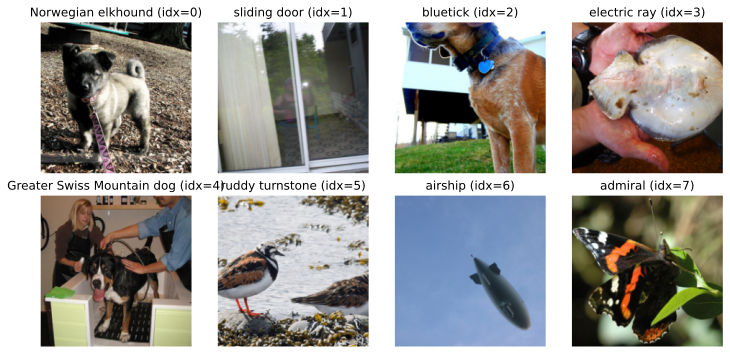

In [22]:
fig, axes = plt.subplots(2, 4, figsize=(10, 5))

for idx, ax in enumerate(axes.reshape(-1)):
    image, category = images[idx], labels[idx]
    raw_image = inv_normalize(image).permute(1, 2, 0).numpy()
    
    plt.imsave(f'./images/image_{idx}.png', raw_image)
    
    ax.set_axis_off()
    ax.imshow(raw_image)
    ax.set_title('{0} (idx={1:d})'.format(categories[category], idx))

fig.tight_layout()
plt.show()

In [23]:
logits = compiled_resnet_model(images.to(device))

In [24]:
predicted_labels = torch.argmax(logits, dim=1)
predicted_labels, labels

(tensor([174, 799, 164,   5, 238, 139, 405, 321], device='cuda:0'),
 tensor([174, 799, 164,   5, 238, 139, 405, 321]))

Сохраним скомпилированный чекпоинт:

In [32]:
compiled_resnet_model.save('./models/resnet50.pt')
compiled_resnet_model_cpu.save('./models/resnet50_cpu.pt')

In [31]:
Code('./resnet.cpp')

#include <filesystem>

#include <torch/cuda.h>
#include <torch/script.h>

#include <opencv2/core.hpp>
#include <opencv2/imgproc.hpp>
#include <opencv2/highgui.hpp>
#include <opencv2/imgcodecs.hpp>

#include "matplotlibcpp.h"
namespace plt = matplotlibcpp;

int main(int argc, const char* argv[]) {
    if(argc < 2) {
        std::cout << "Specify path to a directory with model checkpoint (./models/resnet50.pt) and images folder (./images)" << std::endl;
        return 0;
    }

    std::filesystem::path base_path(argv[1]);
    std::filesystem::path model_path{base_path};
    std::filesystem::path images_path{base_path / "images"};

    // Specify appropriate device
    auto target_device = torch::kCPU;
    if (torch::cuda::is_available()) {
        target_device = torch::kCUDA;
        model_path /= "models/resnet50.pt";
    } else {
        model_path /=  "models/resnet50_cpu.pt";
    }

    torch::jit::script::Module module;
    try {
        // Deserialize the ScriptModule from a file using torch::jit::load().
        module = torch::jit::load(model_path.string(), target_device);
        // Set model into evaluation mode
        module.eval();
    } catch (const c10::Error& e) {
        std::cerr << "Error loading the model: " << e.msg() << std::endl;
        return -1;
    }

    // Use OpenCV to read images
    std::vector<cv::Mat> images;
    for(auto& image_path : std::filesystem::directory_iterator{images_path}) {
        cv::Mat image = imread(image_path.path().string(), cv::IMREAD_COLOR);
        cv::cvtColor(image, image, cv::COLOR_BGR2RGB);

        images.push_back(image);
    }

    // Convert OpenCV images to torch::Tensor
    auto image_tensors = torch::empty(
        {static_cast<int>(images.size()), 224, 224, 3},
        torch::TensorOptions(torch::kUInt8)
    );
    for(int i = 0; i < images.size(); ++i){
        auto image_tensor = torch::from_blob(
                images[i].data, {images[i].rows, images[i].cols, 3},
                torch::TensorOptions(torch::kUInt8)
            );
        image_tensors.select(0, i).copy_(image_tensor);
    }

    // Normalize data
    auto mean = torch::tensor(
            {0.485, 0.456, 0.406},
            torch::TensorOptions(torch::kFloat32)
            ).reshape({1, 3, 1, 1});
    auto std = torch::tensor(
            {0.229, 0.224, 0.225},
            torch::TensorOptions(torch::kFloat32)
            ).reshape({1, 3, 1, 1});
    auto batch = (
        (image_tensors.permute({0, 3, 1, 2}).to(torch::kFloat32) / 255.0 - mean) / std
    ).to(target_device);

    // Wrap input for model
    std::vector<torch::jit::IValue> batch_jit({batch});

    // Perform forward pass
    auto logits = module.forward(batch_jit).toTensor();
    auto predictions = torch::argmax(logits, 1);
    std::cout << "Tensor with predictions: " << predictions << std::endl;

    // Display results
    plt::figure_size(1000, 700);
    for(int i = 0; i < images.size(); ++i){
        std::stringstream ss;
        ss << "Predicted label: " << predictions[i].item<int>();

        plt::subplot(2, images.size() / 2, i + 1);
        plt::imshow(images[i].data, images[i].rows, images[i].cols, 3);
        plt::title(ss.str());
    }
    plt::tight_layout();
    plt::save((base_path / "predictions.png").string(), 500);
    plt::show();
}

## `C++ bindings`

Для того, что бы воспользоваться библиотекой PyTorch из С++ нужно скачать исходники `libtorch` правильной версии.

Также, для работы с картинками из C++ нужно установить библиотеки `OpenCV`, `matplotlibcpp`.

`libtorch` и `matplotlibcpp` будут скачаны и установлены в процессе сборки. Однако `OpenCV` требует дополнительных действий:

#### `OpenCV`

На Windows можно скачать и установить готовые бинарники:

In [ ]:
import urllib.request
    
urllib.request.urlretrieve(
    'https://github.com/opencv/opencv/releases/download/4.7.0/opencv-4.7.0-windows.exe', 
    'opencv-4.7.0-windows.exe'
)

Запомните путь, по которому установлены бинарники:

In [26]:
OpenCV_DIR = 'C:/Toolchain/opencv/build'

На Ubuntu бинарники доступны в пакетном менеджере:
```bash
sudo apt install libopencv-dev python3-opencv
```

На MacOS бинарники также доступны в пакетном менеджере:
```bash
brew install opencv
```

#### `libtorch`

In [27]:
TORCH_VERSION, TORCH_CUDA_VERSION = torch.__version__.split('+')
print(TORCH_VERSION, TORCH_CUDA_VERSION)

2.0.0 cu118


### `Сборка`

Сборка проекта осуществляется с помощью утилиты `cmake`. Для сборки под Windows должна быть установлена Visual Studio.

Если сборка происходит под Linux/MacOS или `OpenCV_DIR` установлена, как глобальная переменная окружения, то удалите из команды опцию `-DOpenCV_DIR={OpenCV_DIR}`:

In [28]:
os.makedirs('./build/', exist_ok=True)
os.chdir('./build/')

! cmake .. -DCMAKE_BUILD_TYPE=Release -DTORCH_VERSION={TORCH_VERSION} -DTORCH_CUDA_VERSION={TORCH_CUDA_VERSION} -DOpenCV_DIR={OpenCV_DIR}

os.chdir('./../')

-- Selecting Windows SDK version 10.0.19041.0 to target Windows 10.0.19045.
-- Found Python3: C:/Toolchain/Python310/python.exe (found version "3.10.6") found components: Interpreter Development Development.Module Development.Embed 
-- Found Python3: optimized;C:/Toolchain/Python310/libs/python310.lib;debug;C:/Toolchain/Python310/libs/python310_d.lib (found version "3.10.6") found components: NumPy Interpreter Development.Module 
-- OpenCV ARCH: x64
-- OpenCV RUNTIME: vc16
-- OpenCV STATIC: OFF
-- Found OpenCV 4.7.0 in C:/Toolchain/opencv/build/x64/vc16/lib
-- You might need to add C:\Toolchain\opencv\build\x64\vc16\bin to your PATH to be able to run your applications.
-- Caffe2: CUDA detected: 11.6
-- Caffe2: CUDA nvcc is: C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.6/bin/nvcc.exe
-- Caffe2: CUDA toolkit directory: C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.6
-- Caffe2: Header version is: 11.6
-- C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.6/lib/x64/n

In [29]:
! cmake --build ./build -j 8 --config Release

Microsoft (R) Build Engine ўҐабЁЁ 16.11.2+f32259642 ¤«п .NET Framework
(C) Љ®аЇ®а жЁп Њ ©Єа®б®дв (Microsoft Corporation). ‚бҐ Їа ў  § йЁйҐ­л.

  fill_inbetween.cpp
  bar.cpp
  fill.cpp
  lines3d.cpp
  contour.cpp
  animation.cpp
  colorbar.cpp
  basic.cpp
  minimal.cpp
  modern.cpp
  fill.vcxproj -> C:\Users\nahod\Documents\torch_api\build\bin\Release\fill.exe
  minimal.vcxproj -> C:\Users\nahod\Documents\torch_api\build\bin\Release\minimal.exe
  nonblock.cpp
  spy.cpp
  bar.vcxproj -> C:\Users\nahod\Documents\torch_api\build\bin\Release\bar.exe
  contour.vcxproj -> C:\Users\nahod\Documents\torch_api\build\bin\Release\contour.exe
  colorbar.vcxproj -> C:\Users\nahod\Documents\torch_api\build\bin\Release\colorbar.exe
  basic.vcxproj -> C:\Users\nahod\Documents\torch_api\build\bin\Release\basic.exe
  lines3d.vcxproj -> C:\Users\nahod\Documents\torch_api\build\bin\Release\lines3d.exe
  modern.vcxproj -> C:\Users\nahod\Documents\torch_api\build\bin\Release\modern.exe
  subplot2grid.cpp
  f

In [30]:
! "./build/Release/torch_api_simple.exe" ./
# Для Linux/MacOS используйте команду:
# ! ./build/torch_api_simple ./

Input tensor: (1,.,.) = 
 Columns 1 to 9  0.7409  0.0156  0.4986  0.5913  0.3095  0.4475  0.6348  0.3204  0.9601

Columns 10 to 10  0.4998

(2,.,.) = 
 Columns 1 to 9  0.4163  0.8298  0.4517  0.1909  0.7699  0.2159  0.1904  0.0829  0.1634

Columns 10 to 10  0.4817

(3,.,.) = 
 Columns 1 to 9  0.7378  0.7706  0.9916  0.7664  0.7898  0.0562  0.8826  0.3710  0.4174

Columns 10 to 10  0.0500

(4,.,.) = 
 Columns 1 to 9  0.1951  0.9620  0.7682  0.8902  0.5649  0.4787  0.1907  0.6389  0.8089

Columns 10 to 10  0.4836

(5,.,.) = 
 Columns 1 to 9  0.3691  0.9938  0.3096  0.0484  0.9723  0.9190  0.9456  0.5640  0.7576

Columns 10 to 10  0.8957

(6,.,.) = 
 Columns 1 to 9  0.8497  0.4408  0.4880  0.6341  0.8325  0.4443  0.0512  0.1191  0.6645

Columns 10 to 10  0.7958

(7,.,.) = 
 Columns 1 to 9  0.5884  0.8729  0.4682  0.7374  0.7990  0.5352  0.3174  0.8848  0.0104

Columns 10 to 10  0.4397
[ CUDAFloatType{7,1,10} ]
Output tensor:  0.4823
 0.4829
 0.4822
 0.4854
 0.4832
 0.4844
 0.4856
[ CUDAFl

In [31]:
! "./build/Release/torch_api_resnet.exe" ./
# Для Linux/MacOS используйте команду:
# ! ./build/torch_api_resnet ./

Tensor with predictions:  174
 799
 164
   5
 238
 139
 405
 321
[ CUDALongType{8} ]
Figure(1000x700)


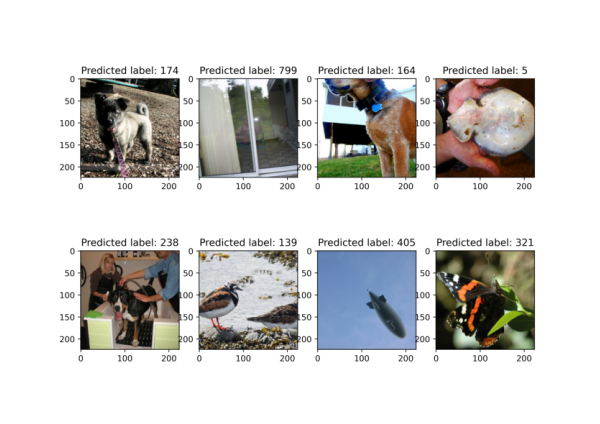

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.imshow(plt.imread('./predictions.png'))
ax.set_axis_off()

fig.tight_layout()
plt.show()